In [ ]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
data_dir='/content/drive/MyDrive/dataskin'

In [ ]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [ ]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [ ]:
# Load and preprocess dataset
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/dataskin')
data = data.map(lambda x, y: (x/255, y))  # Normalize data

Found 1333 files belonging to 2 classes.


In [ ]:
# Split the data into train, validation, and test sets
train_size = int(len(data) * .7)
val_size = int(len(data) * .2)
test_size = int(len(data) * .1)

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [ ]:
# Build the model to classify the images
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 20 classes for multi-class classification

In [ ]:
# Compile the model with multi-class loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

In [ ]:
# Training the model
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
print(val)
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Epoch 1/20
29/29 [==============================] - 11s 319ms/step - loss: 0.7053 - accuracy: 0.6261 - val_loss: 0.7080 - val_accuracy: 0.5000
Epoch 2/20
29/29 [==============================] - 9s 302ms/step - loss: 0.5689 - accuracy: 0.7198 - val_loss: 0.5247 - val_accuracy: 0.7734
Epoch 3/20
29/29 [==============================] - 10s 316ms/step - loss: 0.4941 - accuracy: 0.7748 - val_loss: 0.4869 - val_accuracy: 0.7734
Epoch 4/20
29/29 [==============================] - 9s 307ms/step - loss: 0.4831 - accuracy: 0.7899 - val_loss: 0.4645 - val_accuracy: 0.8164
Epoch 5/20
29/29 [==============================] - 9s 306ms/step - loss: 0.4508 - accuracy: 0.8006 - val_loss: 0.5031 - val_accuracy: 0.7812
Epoch 6/20
29/29 [==============================] - 9s 302ms/step - loss: 0.4048 - accuracy: 0.8297 - val_loss: 0.4387 - val_accuracy: 0.

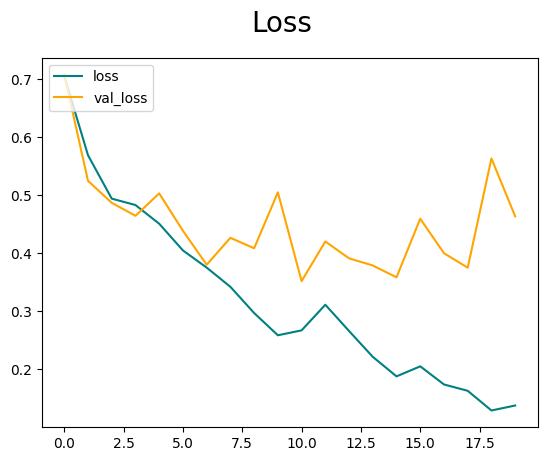

In [ ]:
# Plot the loss and accuracy curves
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

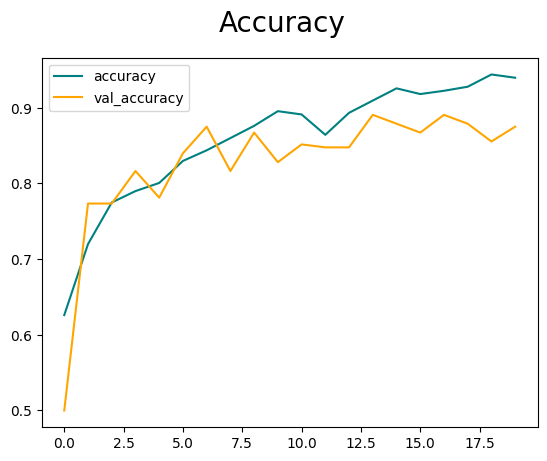

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()


In [ ]:
# Evaluation with Precision, Recall, and Accuracy
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
accuracy = tf.keras.metrics.BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    # Convert yhat to probabilities for the positive class
    yhat = yhat[:, 1]
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

1/1 [==============================] - 0s 94ms/step


In [ ]:
print(f'Precision: {precision.result()}')
print(f'Recall: {recall.result()}')
print(f'Accuracy: {accuracy.result()}')

Precision: 0.707317054271698
Recall: 0.7435897588729858
Accuracy: 0.828125


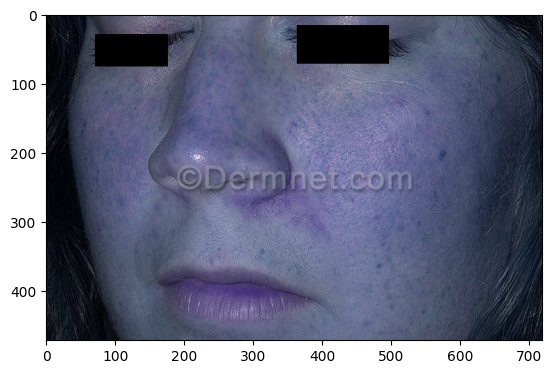

In [ ]:
# Test on a single image (acne or bullous)
import cv2
# img = cv2.imread('/content/data_testing/acnes_testing/acne-closed-comedo-22.jpg')
# img = cv2.imread('/content/data_testing/acnes_testing/acne-cystic-112.jpg')
# img = cv2.imread('/content/data_testing/acnes_testing/acne-cystic-86.jpg')
# img = cv2.imread('')
img = cv2.imread('/content/drive/MyDrive/dataskin/Acne and Rosacea Photos/07PerioralDermNose.jpg')
# img = cv2.imread('/content/drive/MyDrive/dataskin/Acne and Rosacea Photos/07Acne081101.jpg')
plt.imshow(img)
plt.show()

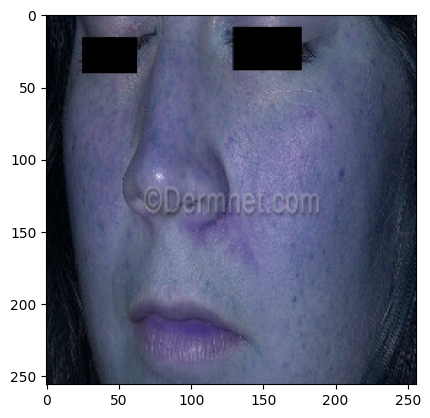

In [ ]:
# Resize image for model input
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize / 255, 0))
output=np.argmax(yhat)
print('Predicted class:', output)  # Output the class (0 for acne, 1 for bullous)

1/1 [==============================] - 0s 32ms/step
Predicted class: 0


In [ ]:
if output==0:
  print('Acne')
elif output==1:
  print('bullous')
else:
  print("sorry thats not found in my brain")

Acne


In [ ]:
model.save('skin_diseas.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import tensorflow as tf
import numpy as np
from keras.preprocessing import image

In [ ]:
from keras.models import load_model
model = load_model('/content/skin_diseas.h5')


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
from keras.preprocessing import image

img = image.load_img('/content/drive/MyDrive/dataskin/Acne and Rosacea Photos/07PerioralDermNose.jpg', target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)



yhat=model.predict(img_array)
output=np.argmax(yhat)

1/1 [==============================] - 0s 80ms/step


In [ ]:
print(output)

0
